<a href="https://colab.research.google.com/github/racs2019/Data-Science-Basics-Series/blob/main/Multinomial_Logistic_Regression_for_Ancestry_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multinomial Logistic Regression for Ancestry Classification


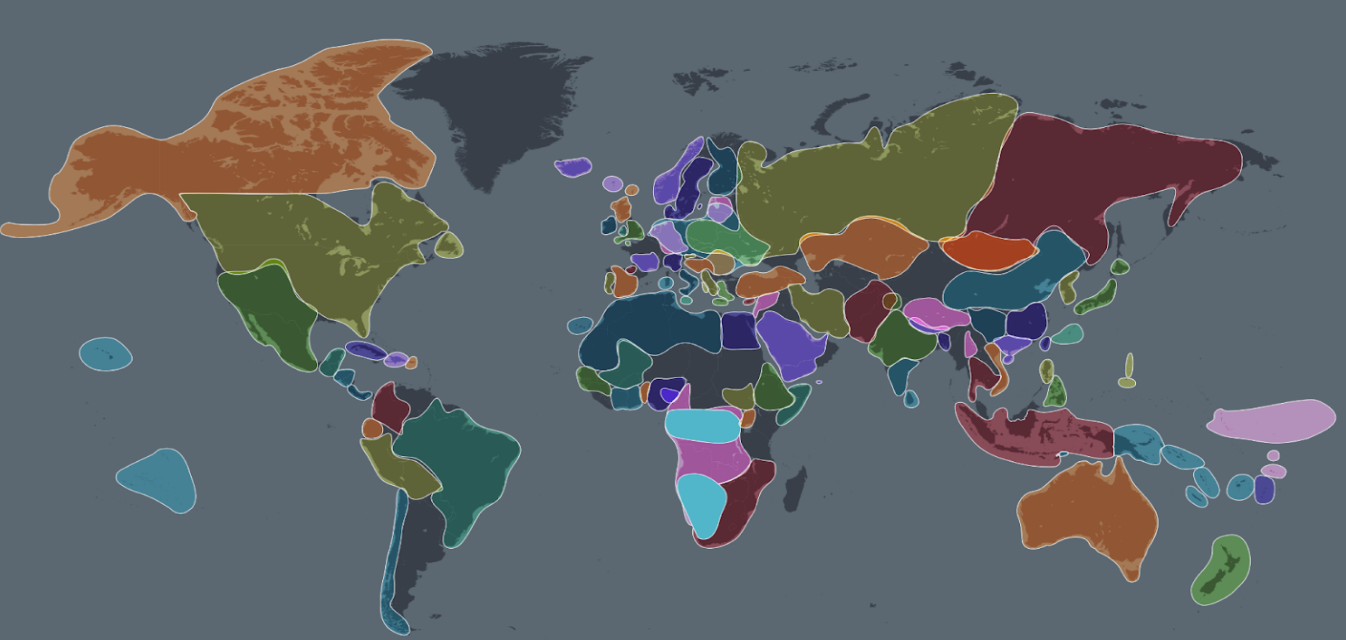

This assignment focuses on classifying ancestry based on genetic data. There are five different possible continental ancestries (African, European, East Asian, Oceanian, or Native American), and multinomial logistic regression with ridge penalization is used for the classification model. Overall, this assignment demonstrates a classification task in the real-world context of ancestry determination.



---



##Data, Parameter, and Functions Preparation

This section prepares the training and test data from different csv files into numpy arrays and sets up the design and response matrices for matrix multiplication in the batch decent multinomial logistic regression with ridge penalization. During this process, the design and response matrices are used to create different dataset cohorts for the full dataset, test dataset, and for the 5-fold cross validation training and validation datasets. This section also creates functions to initialize a beta parameter matrix of all zeros and standardize and center the different data cohorts created after splitting into the full dataset, test dataset, and the 5-fold cross validation dataset. The main ridge multinomial logistic regression function which updates the beta parameters is also included in this section.





In [ ]:
#Dependencies
import pandas as pd
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
import numpy as np
import warnings
import math
from prettytable import PrettyTable

#Data csv
url = 'https://raw.githubusercontent.com/racs2019/CAP-5625-A4-Data/main/TrainingData_N183_p10.csv'
df = pd.read_csv(url)

#Test data csv
test_url = 'https://raw.githubusercontent.com/racs2019/CAP-5625-A4-Data/main/TestData_N111_p10.csv'
test_df = pd.read_csv(test_url)

In [ ]:
#Display dataset dataframe
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,-10.901171,0.798743,-1.143301,-1.070960,11.856396,-2.265965,4.536405,1.519959,-2.214294,-0.671274,African
1,-9.990054,1.416821,-0.729626,-0.443621,10.418594,0.443514,2.640659,-4.637746,3.351629,-0.671274,African
2,-9.345388,2.913054,-0.921421,0.029173,10.672615,-2.052552,5.140476,-1.451096,0.444183,-0.671274,African
3,-11.221507,1.733021,-2.339817,0.045786,13.195087,-3.068897,2.863434,-2.259194,2.374566,-0.671274,African
4,-10.175158,2.066307,-0.785493,-0.632400,7.461272,-1.643509,0.715258,-3.982752,0.098681,-0.671274,African


In [ ]:
#Response matrix from dataframe
ytemp = df['Ancestry'].to_numpy()
y = np.zeros((183,5))
for i in range(183):
  if ytemp[i] == 'African':
    y[i][0] = 1
  elif ytemp[i] == 'EastAsian':
    y[i][1] = 1
  elif ytemp[i] == 'European':
    y[i][2] = 1
  elif ytemp[i] == 'NativeAmerican':
    y[i][3] = 1
  elif ytemp[i] == 'Oceanian':
    y[i][4] = 1

In [ ]:
#Design matrix from dataframe
xtemp = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']].to_numpy()
x = np.array(xtemp, dtype='float')

In [ ]:
#Design matrix from test dataframe
xtemp_test = test_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']].to_numpy()
test_x = np.array(xtemp_test, dtype='float')

In [ ]:
#----------------------------------------------------
#Split dataset into 5-fold cross validation datasets
#----------------------------------------------------

#Full dataset used to train model on all data
x_full = cp.deepcopy(x)
y_full = cp.deepcopy(y)

#Randomly shuffles and splits into 5 batches/folds the reponse and design vectors the same way
shuffler = np.random.permutation(len(x))
Xb = x[shuffler]
Yb = y[shuffler]
x_split = np.array_split(Xb, 5)
y_split = np.array_split(Yb, 5)

#x_training_five_fold and y_training_five_fold contain the traning datasets for 5 fold CV
x_training_five_fold = [[], [], [], [], []]
y_training_five_fold = [[], [], [], [], []]

#x_validation_five_fold and y_validation_five_fold contains the validation datasets
x_validation_five_fold = [[], [], [], [], []]
y_validation_five_fold = [[], [], [], [], []]

#Performs the 5-fold cross validation split
for i in range(5):
  temp_x = []
  temp_y = []
  flag = 0
  for j in range(5):
    if j != i:
      if flag == 0:
        temp_x = x_split[j]
        temp_y = y_split[j]
        flag = 1
      elif flag == 1:
        temp_x = np.append(temp_x, x_split[j], axis=0)
        temp_y = np.append(temp_y, y_split[j], axis=0)
    else:
      x_validation_five_fold[i] = x_split[j]
      y_validation_five_fold[i] = y_split[j]
  x_training_five_fold[i] = temp_x
  y_training_five_fold[i] = temp_y

In [ ]:
#------------------------------------------------
#Functions to standardize and center the datasets
#------------------------------------------------

#standardization function for traning dataset
def standardize(data):
  mean_array = np.mean(data, axis=0)
  std_array = np.std(data, axis=0)

  for i in data:
    for j in range(0,10):
      i[j] = (i[j] - mean_array[j])/std_array[j]

#standardization function for validation/test dataset, uses mean/std from training dataset
def standardize_val(data, validation):
  mean_array = np.mean(data, axis=0)
  std_array = np.std(data, axis=0)

  for i in validation:
    for j in range(0,10):
      i[j] = (i[j] - mean_array[j])/std_array[j]

In [ ]:
#Perform centering and standardization on traning dataset and validation/test dataset (using mean and std from training data)
for i in range(0,5):
  standardize_val(x_training_five_fold[i], x_validation_five_fold[i])
  standardize(x_training_five_fold[i])

standardize_val(x_full, test_x)
standardize(x_full)

In [ ]:
#Add column of 1s to x datasets
x_full = np.concatenate((np.ones(len(x_full))[:, np.newaxis], x_full), axis=1)
test_x = np.concatenate((np.ones(len(test_x))[:, np.newaxis], test_x), axis=1)
for i in range(5):
  x_training_five_fold[i] = np.concatenate((np.ones(len(x_training_five_fold[i]))[:, np.newaxis], x_training_five_fold[i]), axis=1)
  x_validation_five_fold[i] = np.concatenate((np.ones(len(x_validation_five_fold[i]))[:, np.newaxis], x_validation_five_fold[i]), axis=1)

In [ ]:
#Function to initialize (𝑝 + 1) × 𝐾-dimensional parameter matrix to all zeros
def init_beta():
  beta = np.zeros((11, 5))
  return(beta)

In [ ]:
#Main multinomial logistic regression with ridge penalization function
def multi_ridge_regression(alpha, lmbda, beta, x, y):
  for i in range(10000):
    #Compute the class probability matrix
    U = np.dot(x, beta)
    for i in range(len(U)):
      for j in range(len(U[0])):
        U[i][j] = math.exp(U[i][j])

    #Normalized Class probability Matrix
    P = np.ones((len(x), 5))
    for i in range(len(x)):
      row_sum = 0
      for j in range(5):
        row_sum = row_sum + U[i][j]
      for q in range(5):
        P[i][q] = (U[i][q]/row_sum)

    #Intercept Matrix
    Z = np.zeros((11, 5))
    Z[0] = beta[0]

    #Main gradient decent update
    beta = beta + alpha * (np.dot(np.transpose(x), (y - P)) - np.dot((2 * lmbda), (beta - Z)))
  return beta

##Multinomial Logistic Regression on Full Dataset with Varying λ *(Deliverable 1)*

This section trains multinomial logistic regression with ridge penalization on the full dataset for each value of λ = [10^-4, 10^-3, 10^-2, ..., 10^4] at an alpha value of 10^-5. For each of the k=5 classes (African, European, East Asian, Oceanian, or Native American), the resulting beta vectors from the respective λ value is then stored in an array and plotted to show how each feature/beta coefficient changes as we increased the λ value. Each individual graph demonstrates how the features shrink towards zero as the λ value is increased.



In [ ]:
#Function to run multinomial logistic regression for each value λ = [10^-4, 10^-3, 10^-2, ..., 10^4]
#and returns beta values for plotting for a given alpha parameter value
def multi_ridge_tuning(x, y, alpha):
  beta_array = []
  for i in range(0, 9):
    beta = init_beta()
    beta = multi_ridge_regression(alpha, 10**(i-4), beta, x, y)
    beta_array.append(beta)

  #Convert the array of all beta values for each λ value into an array of values for a single beta as λ increases
  lmbda_array_African = [[], [], [], [], [], [], [], [], [], [], []]
  lmbda_array_EastAsian = [[], [], [], [], [], [], [], [], [], [], []]
  lmbda_array_European = [[], [], [], [], [], [], [], [], [], [], []]
  lmbda_array_NativeAmerican = [[], [], [], [], [], [], [], [], [], [], []]
  lmbda_array_Oceanian = [[], [], [], [], [], [], [], [], [], [], []]

  for z in beta_array:
      for i in range(0,11):
        lmbda_array_African[i].append(z[i][0])
        lmbda_array_EastAsian[i].append(z[i][1])
        lmbda_array_European[i].append(z[i][2])
        lmbda_array_NativeAmerican[i].append(z[i][3])
        lmbda_array_Oceanian[i].append(z[i][4])

  return lmbda_array_African, lmbda_array_EastAsian, lmbda_array_European, lmbda_array_NativeAmerican, lmbda_array_Oceanian

In [ ]:
#Function to plot the effect of λ value on the beta value of each feature/beta parameter
#Requires the final beta value array returned by the multi_ridge_tuning function and the alpha value and ancestry
def plot_differet_lmbda(lmbda_array, a, ancestry):
  label = ['BO', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
  for i in range(1,11):
    plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], lmbda_array[i], label=label[i])
  plt.title((ancestry + '\nBeta Coefficients VS Lambda Parameter at Alpha = ' +  str(a)))
  plt.xlabel("Log10(lambda)")
  plt.ylabel("Beta (B1, B2, B3, B4...B10)")
  leg = plt.legend(loc='best', bbox_to_anchor=(1,1))
  plt.show()

In [ ]:
lmbda_array_African, lmbda_array_EastAsian, lmbda_array_European, lmbda_array_NativeAmerican, lmbda_array_Oceanian = multi_ridge_tuning(x_full, y_full, 10**(-5))

###African

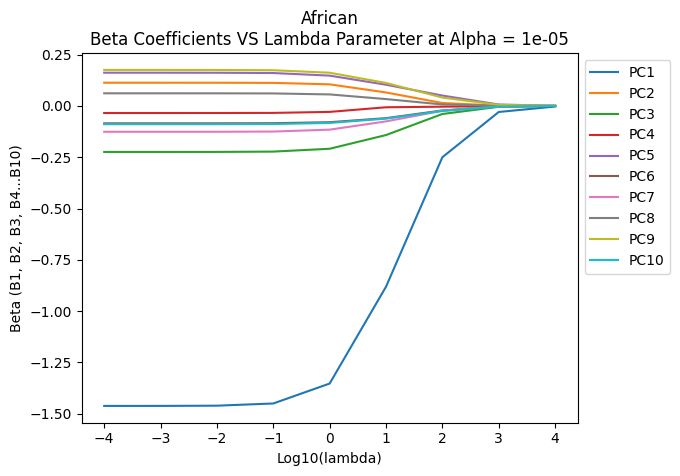

In [ ]:
plot_differet_lmbda(lmbda_array_African, 10**(-5), 'African')

###East Asian

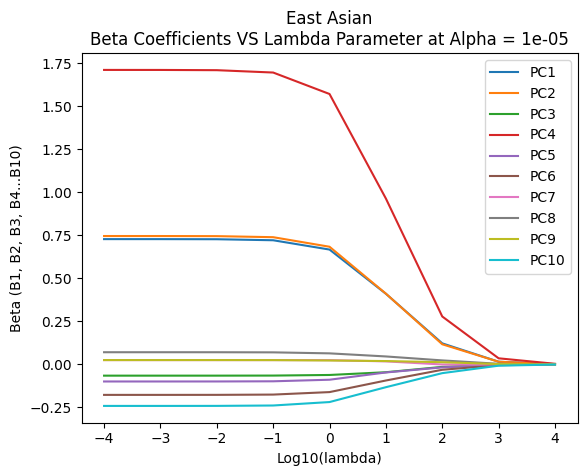

In [ ]:
plot_differet_lmbda(lmbda_array_EastAsian, 10**(-5), 'East Asian')

###European

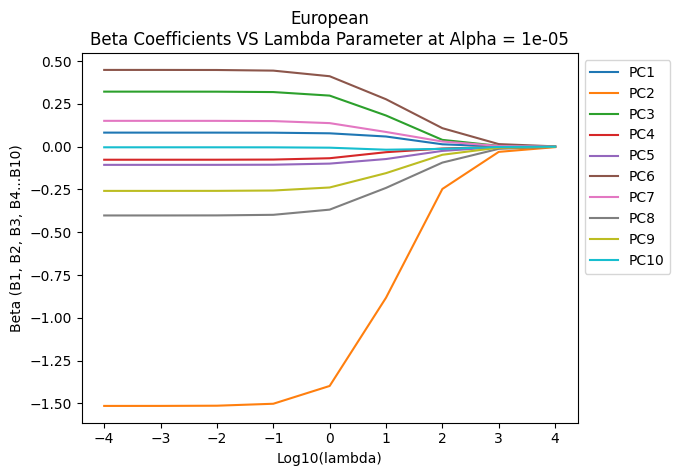

In [ ]:
plot_differet_lmbda(lmbda_array_European, 10**(-5), 'European')

###Native American

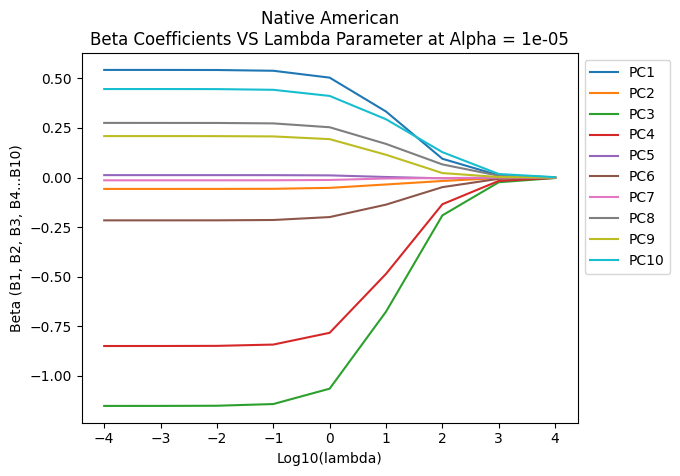

In [ ]:
plot_differet_lmbda(lmbda_array_NativeAmerican, 10**(-5), 'Native American')

###Oceanian

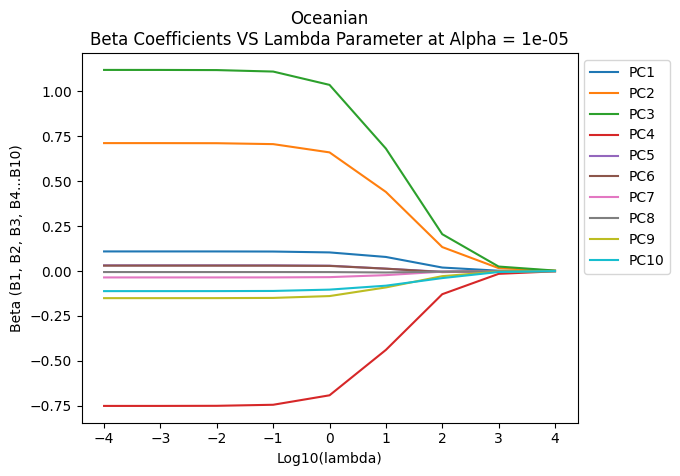

In [ ]:
plot_differet_lmbda(lmbda_array_Oceanian, 10**(-5), 'Oceanian')

##5-Fold Cross Validation *(Deliverable 2-3)*

This section trains the 5-fold cross validation dataset on the multinomial logistic regression with ridge penalization and calculates the 5-fold cross-validation CCE error using the validation dataset. For the error, we calculate the categorical cross entropy instead of the MSE used in the previous assignments. The model is run on the cross-validation dataset for each value of λ = [10^-4, 10^-3, 10^-2, ..., 10^4], and the CCE is computed for each value of λ. Finally, the CV CCE is plotted against the respective λ value to show the cross validation error curve. The graph shows that significantly increasing the lambda value resulted in worse performance as important coefficients were being forcibly shrunk towards zero.




In [ ]:
#Run multinomial logistic regression with five fold cross validation for each value λ = [10^-4, 10^-3, 10^-2, ..., 10^4]
#and store beta values. Store validation CCE from each varying λ iteration into an array for plotting.
CCE_array = [0, 0, 0, 0, 0, 0, 0, 0, 0]
for j in range(0, 9):
  for i in range(0, 5):
    #Rn multinomial logistic regression
    beta = init_beta()
    beta = multi_ridge_regression(10**(-5), 10**(j-4), beta, x_training_five_fold[i], y_training_five_fold[i])

    #Compute the class probability matrix
    U = np.dot(x_validation_five_fold[i], beta)
    for q in range(len(U)):
      for w in range(len(U[0])):
        U[q][w] = math.exp(U[q][w])

    #Normalized Class probability Matrix
    P = np.ones((len(x_validation_five_fold[i]), 5))
    for m in range(len(x_validation_five_fold[i])):
      row_sum = 0
      for n in range(5):
        row_sum = row_sum + U[m][n]
      for q in range(5):
        P[m][q] = (U[m][q]/row_sum)

    #Calculate categorical cross entropy for CV error
    CCE = 0
    for z in range(len(y_validation_five_fold[i])):
      for y in range(5):
        CCE = CCE + y_validation_five_fold[i][z][y] * math.log10(P[z][y])
    CCE_array[j] = CCE_array[j] + CCE * (-1/len(y_validation_five_fold[i]))
  CCE_array[j] = (CCE_array[j]/5)

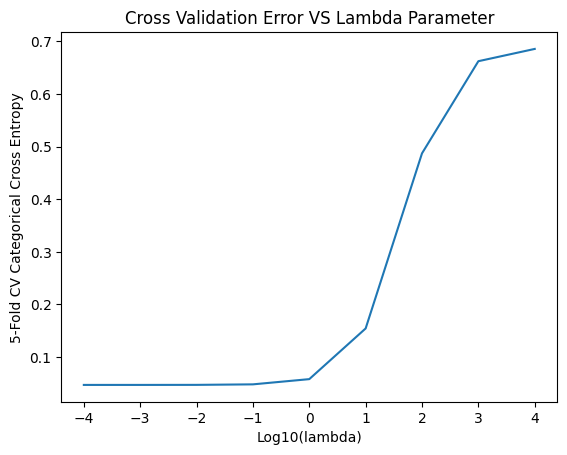

In [ ]:
#Plot the effect of λ value on the cross validation error
plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], CCE_array)
plt.title("Cross Validation Error VS Lambda Parameter")
plt.xlabel("Log10(lambda)")
plt.ylabel("5-Fold CV Categorical Cross Entropy")
plt.show()

In [ ]:
#Display the minimum CV error and the respective λ value
print('Minimum CV error and respective λ value:\n-----------------------------------')
min_CV = min(CCE_array)
print('CV error: ', min_CV)
print('λ = ', 10**(CCE_array.index(min_CV)-4))

Minimum CV error and respective λ value:
-----------------------------------
CV error:  0.046950283001745384
λ =  0.0001


##Optimal λ on Full Dataset *(Deliverable 4)*

This section re-trains the multinomial logistic regression with ridge penalization model on the entire dataset using an alpha value of 10^-5 and the optimal λ value found in the previous section when comparing CV error. The final beta coefficients matrix is then displayed along with the respective feature labels.

In [ ]:
#Run algorithm on model with optimal lambda value on full dataset and store the final beta values
beta = init_beta()
beta = multi_ridge_regression(10**(-5), 0.0001, beta, x_full, y_full)

In [ ]:
#Print the final beta parameters in a table
beta_table = PrettyTable()
K = ['African', 'EastAsian', 'European', 'NativeAmerican', 'Oceanian']
betas = ['𝛽̂0 (intercept)', '𝛽̂1 (PC1)', '𝛽̂2 (PC2)', '𝛽̂3 (PC3)', '𝛽̂4 (PC4)', '𝛽̂5 (PC5)', '𝛽̂6 (PC6)', '𝛽̂7 (PC7)', '𝛽̂8 (PC8)', '𝛽̂9 (PC9)', '𝛽̂10 (PC10)']
beta_table.field_names = K
for i in range(len(beta)):
  beta_table.add_row(beta[i])

fieldname = '𝛽̂ parameter'
beta_table._field_names.insert(0, fieldname)
beta_table._align[fieldname] = 'c'
beta_table._valign[fieldname] = 't'
for i, _ in enumerate(beta_table._rows):
    beta_table._rows[i].insert(0, betas[i])
beta_table.align = "l"

print('--------------------------------------------------------------------------------')
print('Final estimates 𝛽̂ = [𝛽̂0, 𝛽̂2, 𝛽̂3, ..., 𝛽̂10] for each class with best λ (λ=0.0001)')
print(beta_table)

--------------------------------------------------------------------------------
Final estimates 𝛽̂ = [𝛽̂0, 𝛽̂2, 𝛽̂3, ..., 𝛽̂10] for each class with best λ (λ=0.0001)
+----------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+
| 𝛽̂ parameter    | African              | EastAsian            | European             | NativeAmerican        | Oceanian              |
+----------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+
| 𝛽̂0 (intercept) | -0.25321114143145734 | 0.5708979860241069   | -0.01645926205052106 | -0.06393467556604307  | -0.23729290697609046  |
| 𝛽̂1 (PC1)       | -1.4616707777793048  | 0.7282109778854853   | 0.08175354299123175  | 0.5425705215716915    | 0.10913573533090486   |
| 𝛽̂2 (PC2)       | 0.11294978081299736  | 0.7461906885482815   | -1.5141544342616111  | -0.05732990602471429  | 0.71234387092505      |
| 𝛽̂3 (PC3)  

##Predictions on Test Data *(Deliverable 4)*

This final section utilizes the re-trained optimal model to make ancestry predictions on the test data. The predictions are displayed as normalized class probabilities as well which ancestry the sample most likely belongs to (maximum probability). The result table shows all the probabilities for each sample, the original origin, the most likely probability, and the highlighted maximum probability.



In [ ]:
#Display dataset dataframe
test_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,2.517683,5.464283,9.067873,-4.965928,-0.741937,0.039785,0.573279,-0.216918,2.454823,-0.671274,Unknown
1,6.077012,1.032867,-5.795883,-3.490064,-0.600204,-0.120803,1.243767,1.821390,-1.173053,2.442467,Unknown
2,1.016945,-2.913299,0.907702,1.233580,-1.983452,1.605964,2.674998,-0.732921,-2.157438,-0.671274,Unknown
3,-10.860926,2.545077,0.023950,-1.474450,0.372286,-2.609954,-2.794092,1.264747,-3.974644,-0.671274,Unknown
4,4.790262,3.621650,-1.442221,5.459907,-0.864235,-2.591185,-0.062762,0.515344,0.228729,-0.671274,Unknown


In [ ]:
#Calculate predicted normalized probabilities for the test data using final beta values
U_test = np.dot(test_x, beta)
for q in range(len(U_test)):
  for w in range(len(U_test[0])):
    U_test[q][w] = math.exp(U_test[q][w])

P_test = np.ones((len(test_x), 5))
for m in range(len(test_x)):
  row_sum = 0
  for n in range(5):
    row_sum = row_sum + U_test[m][n]
  for q in range(5):
    P_test[m][q] = (U_test[m][q]/row_sum)

In [ ]:
#The code below formats the predictions into a table
P_rounded = np.round(P_test, 7)
max = P_rounded.max(axis=1)
index_array = []

P_list = P_rounded.tolist()
for i in range(len(max)):
  index = np.where(P_rounded == max[i])[1][0]
  index_array.append(index)
  max_str = '\033[0;30;47m ' + str(max[i]) + " \033[0m"
  P_list[i][index] = max_str

table = PrettyTable()
Ancestry = ['Number', 'African', 'EastAsian', 'European', 'NativeAmerican', 'Oceanian']
most_probable_ancestry = []
table.field_names = Ancestry
for i in range(len(P_list)):
  table.add_row([i+1] + P_list[i])
  most_probable_ancestry.append(Ancestry[index_array[i]+1])
table.add_column("Origin", test_df['Ancestry'].to_numpy())
table.add_column("Probable Ancestry", most_probable_ancestry)
table.align = "l"

In [ ]:
#Print the formated preiction probability table
print('+--------+-------------+-------------+-------------+----------------+-------------+-----------------+-------------------+')
print('|                         TEST DATA PREDICTION PROBABILITIES AND MOST PROBABLE ANCESTRY                                 |')
print(table)

+--------+-------------+-------------+-------------+----------------+-------------+-----------------+-------------------+
|                         TEST DATA PREDICTION PROBABILITIES AND MOST PROBABLE ANCESTRY                                 |
+--------+-------------+-------------+-------------+----------------+-------------+-----------------+-------------------+
| Number | African     | EastAsian   | European    | NativeAmerican | Oceanian    | Origin          | Probable Ancestry |
+--------+-------------+-------------+-------------+----------------+-------------+-----------------+-------------------+
| 1      | 0.0077146   | 0.0049973   | 0.0060576   | 0.0045072      |  0.9767232  | Unknown         | Oceanian          |
| 2      | 0.0019037   | 0.003108    | 0.0089633   |  0.9832539     | 0.0027711   | Unknown         | NativeAmerican    |
| 3      | 0.0114209   | 0.0371108   |  0.9331746  | 0.0072016      | 0.0110921   | Unknown         | European          |
| 4      |  0.9311295  |

##Discussion Questions *(Deliverable 5)*

**How do the class label probabilities differ for the Mexican and African American samples when compared to the class label probabilities for the unknown samples? Are these class probabilities telling us something about recent history? Explain why these class probabilities are reasonable with respect to knowledge of recent history.**


When comparing the class label probabilities of the different samples, it is clear that the unknown samples had a strongly singular ancestry. Each unknown sample had a very clear class label with a probability of greater than 93%, indicating that those individuals were very strongly from one specific region/ancestry with very little inter-continental mixing in their family tree. On the other hand, the class label probabilities for the Mexican and African American samples were not as clearly one sided in many cases. For the Mexican individuals, most of the samples had a significant probability split between European and Native American origin. Some samples leaned more heavily towards European or Native American, but none of the samples had probabilities for one class as high as the unknown samples. This indicates that these samples were much more of a mix of European and Native American ancestry, which is reasonable given the historical intermixing of individuals from Europe and the natives in Mexico when colonizers first came over into the Americas. Overtime, the two distinct ancestries settled down in the same areas, resulting in genetic intermixing and the ancestral European/Native American split seen in the present day genetic samples. The African American samples had a higher probability of being African, but followed a similar trend as the Mexican individuals. Many of the African American samples had a smaller probability of European ancestry as well as the larger African probability, which makes sense given the historical intermixing of Africans that were brought to the United States with the European locals which formed the majority of the US population. Another interesting trend that gives insight into recent history is that among the Mexican and African American samples there are slight yet increased (compared to the unknown samples) probabilities of ancestry from Oceania and East Asia. For example, sample number 84 had a 47% chance of being African, 14% chance of East Asian, 5% chance of European, 31% chance of Native American, and 3% chance of Oceanian. This indicates that there is much more inter-continental ancestry mixing occurring in recent history as a result of modern transportation, technology, and immigration, resulting in individuals that contain a more split ancestry among many different continents.
